In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display
import getpass
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage,SystemMessage, ToolMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from tavily import TavilyClient
from typing import Literal

c:\Users\lenovo\Desktop\Agents\Neura_Command\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your TAVILY API key: ")
    

# TOOLS

In [3]:
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

@tool
def internet_search(
    query: str,
    max_results: int = 5,
    start_date: str = None,
    end_date: str = None,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = False,
):
    """Run a tavily web search
    Args:
        query: The search query. str
        max_results: The maximum number of results to return. int
        start_date: The start date for the search in YYYY-MM-DD format. str
        end_date: The end date for the search in YYYY-MM-DD format. str
        topic: The topic of the search. Can be "general", "news", "finance". str
        include_raw_content: Whether to include the raw content of the results. boolean
    """
    return tavily_client.search(
        query,
        max_results=max_results,
        start_date= start_date,
        end_date= end_date,
        include_raw_content=include_raw_content,
        topic=topic,
    )

# LLM

In [4]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    
)
tools = [internet_search]
tools_by_name = {tool.name: tool for tool in tools}
llmwithtools = llm.bind_tools(tools)

# NODE

In [12]:
def call_llm_node(state: MessagesState):
    
    messages = state["messages"]
    print("-----"*50)
    print(f"\nAll Messages = {messages}\n")
    print("-----"*50)
    print(f"\nLast message = {messages[-1]}\n")
    print("-----"*50)
    response = llmwithtools.invoke(messages)
    return {"messages": [response]}

In [6]:
def execute_tool_calls_node(state: MessagesState):
    last_message = state["messages"][-1]
    tool_outputs = []
    for tool_call in last_message.tool_calls:
        if tool_call["name"] == "internet_search":
            result = internet_search.invoke(tool_call["args"])
            tool_outputs.append(ToolMessage(tool_call_id=tool_call['id'], content=str(result)))
        # Add other tool handling as needed
    return {"messages": tool_outputs}


In [7]:
def should_call_tools(state: MessagesState):
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# GRAPH

In [13]:
graph = StateGraph(MessagesState)
graph.add_node("llm_node", call_llm_node)
graph.add_node("execute_tool_calls_node", execute_tool_calls_node)

graph.add_edge(START,"llm_node")
graph.add_conditional_edges(
    "llm_node", 
    should_call_tools,
    {
        "tools": "execute_tool_calls_node",
        "end": END,
    }
)
graph.add_edge("execute_tool_calls_node", "llm_node")


checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)
config = {"configurable": {"thread_id": "SigmaBoy1"}}

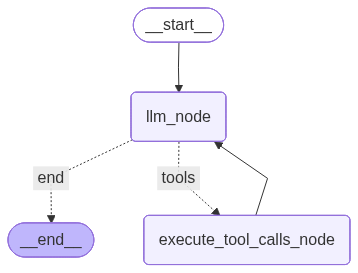

In [9]:
# use the compiled app (CompiledStateGraph) which exposes the graph
display(Image(app.get_graph().draw_mermaid_png()))

# RESULTS

In [ ]:
input1 = {"messages": [SystemMessage(content="You are a helpful Agentic AI. You have tools use as per need."), HumanMessage(content="tell me all instructions given by me?")]}

In [ ]:
results = app.invoke(input1, config)

print("Final result:", results)
ai_msg = results["messages"][-1]
ai_msg.pretty_print()

In [14]:
async for event in app.astream_events(input1, config):
    if event["event"] == "on_chat_model_stream":
        chunk = event["data"]["chunk"].content
        if chunk:
            print(chunk, end="", flush=True)


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

All Messages = [SystemMessage(content='You are a helpful Agentic AI. You have tools use as per need.', additional_kwargs={}, response_metadata={}, id='01c96324-bb9f-4d4e-896a-2b3bff236984'), HumanMessage(content='what is your system instructions?', additional_kwargs={}, response_metadata={}, id='2c69738a-3e7e-41ec-b7b0-76ab17e19010')]

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Last message = content='what is your system instructions?' additional_kwargs={} response_metadata={} id='2c69738a-3e7e-41ec-b7b0-76ab17e19010'

--------------

In [ ]:
lst = results["messages"][-1]
for tool_call in lst.tool_calls:
    print(tool_call['id'])

# CHECKPOINT TESTING

In [ ]:
# checkpointer = MemorySaver()
# config = {"configurable": {"thread_id": "SigmaBoy_2"}}
latest_checkpoint = checkpointer.get(config)
messages = latest_checkpoint["channel_values"]["messages"]
print(messages)
last_ai_msg = None
for msg in reversed(messages):
    if msg.__class__.__name__ == "AIMessage":
        last_ai_msg = msg.content
        break
print("*"*100)
print(last_ai_msg)